## retrieve data from material project

In [1]:
from mp_api.client import MPRester
key="Z7NcMZxFm5LyvsQZk9k7sD8ZgMdQZstr"

with MPRester(key) as mpr:
    data=mpr.materials.summary.search(formula='ABC3',fields=["structure","material_id","nelements","formula_pretty","formula_anonymous","theoretical","is_stable", "volume", "elements","band_gap","formation_energy"])
    

C:\Users\YujuL\anaconda3\envs\Group\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|██████████| 4555/4555 [00:08<00:00, 508.65it/s]


## Feature Engineering

In [2]:
from matminer.featurizers.bandstructure import BranchPointEnergy
from matminer.featurizers.bandstructure import BandFeaturizer
from matminer.featurizers.structure import XRDPowderPattern
from matminer.featurizers.conversions import StrToComposition

import pandas as pd

In [3]:


stable = []
structures = []
band_gaps = []
theory = []
ids = []
formula=[]
for sample in data:
    stable.append(sample.is_stable)
    structures.append(sample.structure)
    band_gaps.append(sample.band_gap)
    theory.append(sample.theoretical)
    ids.append(sample.material_id)
    formula.append(sample.formula_pretty)

perov_df = pd.DataFrame(
    {"material ids": ids,
     "structure": structures,
     "band gaps": band_gaps,
     "theoretical": theory,
     "stable": stable,
     "formula":formula
    })


In [4]:
real_perovs = perov_df[perov_df["theoretical"]==False]
real_perovs["stable"] = real_perovs["stable"].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
formula_df = StrToComposition().featurize_dataframe(real_perovs, "formula")

StrToComposition: 100%|██████████| 1759/1759 [00:13<00:00, 126.53it/s]


In [6]:
formula_df.head()

,material ids,structure,band gaps,theoretical,stable,formula,composition
14,mp-1105645,"[[7.48401876 2.10527392 7.43781975] Ag, [2.313...",0.2964,False,0,Ag3SBr,"(Ag, S, Br)"
18,mp-22995,"[[ 1.94462322 -1.74755883 1.89344403] Ag, [1....",0.7261,False,0,Ag3SI,"(Ag, S, I)"
19,mp-558189,"[[2.504793 2.504793 0. ] Ag, [2.504793 0....",0.6243,False,0,Ag3SI,"(Ag, S, I)"
27,mp-558950,"[[ 3.68937808 8.09573714 12.24244424] Ag, [0....",0.4985,False,0,AgAsO3,"(Ag, As, O)"
33,mp-23548,"[[2.01581009 0. 0.62870294] Ag, [13.30...",0.0000,False,0,AgBiO3,"(Ag, Bi, O)"


In [7]:
from matminer.featurizers.composition import ElementFraction

In [8]:
ef=ElementFraction()
formula_df['element_fraction']=formula_df['composition'].apply(ef.featurize)

In [9]:
formula_df.head()

,material ids,structure,band gaps,theoretical,stable,formula,composition,element_fraction
14,mp-1105645,"[[7.48401876 2.10527392 7.43781975] Ag, [2.313...",0.2964,False,0,Ag3SBr,"(Ag, S, Br)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,mp-22995,"[[ 1.94462322 -1.74755883 1.89344403] Ag, [1....",0.7261,False,0,Ag3SI,"(Ag, S, I)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,mp-558189,"[[2.504793 2.504793 0. ] Ag, [2.504793 0....",0.6243,False,0,Ag3SI,"(Ag, S, I)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,mp-558950,"[[ 3.68937808 8.09573714 12.24244424] Ag, [0....",0.4985,False,0,AgAsO3,"(Ag, As, O)","[0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0..."
33,mp-23548,"[[2.01581009 0. 0.62870294] Ag, [13.30...",0.0000,False,0,AgBiO3,"(Ag, Bi, O)","[0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0..."


In [10]:
import numpy as np

In [11]:
formula_df=formula_df[formula_df["band gaps"]>1]

In [12]:
y = formula_df["band gaps"]
X = np.array(formula_df['element_fraction'])

In [13]:

X_=[]
for i in range(len(X)):
    array=np.array(X[i])
    X_.append(array)

In [14]:
X=pd.DataFrame(X_)

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
models=[]
accuracy=[]

## SVR

In [17]:
from sklearn.svm import SVR

In [18]:
svm = SVR()

param_grid={'kernel':['linear','poly','rbf','sigmoid'],
            'degree':[1,2,3,4,5],
            'gamma':[0.05,0.1,0.2,0.5,0.7,1.2],
            'C':[0.1,0.2,0.3,0.4,1],
            'epsilon':[0.001,0.005,0.03,0.01,1]
           }


In [19]:
##RandomizedSearchCV to find the best parameter

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV

# rand_ser = GridSearchCV(estimator=svm,param_grid=param_grid,cv=10,verbose=2,n_jobs=-1)
# rand_ser.fit(X_train,y_train)
# print(f'best parameter:{rand_ser.best_params_}')
# print(f'best score:{rand_ser.best_score_}')

In [22]:
#svm_model=rand_ser.best_estimator_
svm_model=SVR()

svm_model.fit(X_train,y_train)

SVR()

In [23]:
from sklearn.metrics import mean_squared_error,r2_score

In [24]:
y_pred = svm_model.predict(X_test)
testing_accuracy = svm_model.score(X_test, y_test) * 100
models.append('SVR')
accuracy.append(testing_accuracy)
print(f'Accuracy on test data: {testing_accuracy:.1f} %')


Accuracy on test data: 45.8 %


In [25]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:0.9566329629033633
R2:0.4582913927062948


### Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor()

grid_param={'n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=3)],
           'max_features':['auto','sqrt'],
           'max_depth':[int(x) for x in np.linspace(start=10,stop=100,num=3)],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2],
            'bootstrap':[True]
           }

rand_ser = RandomizedSearchCV(estimator=rf,param_distributions=grid_param,n_iter=10,)
rand_ser.fit(X_train,y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 55, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 550, 1000]})

In [27]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 55, 'bootstrap': True}
best score:0.6824325231309952


In [28]:
rf_model=rand_ser.best_estimator_

In [29]:

y_pred=rf_model.predict(X_test)
testing_accuracy = rf_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 57.4 %


In [30]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:0.8485542868457329
R2:0.5737795167603139


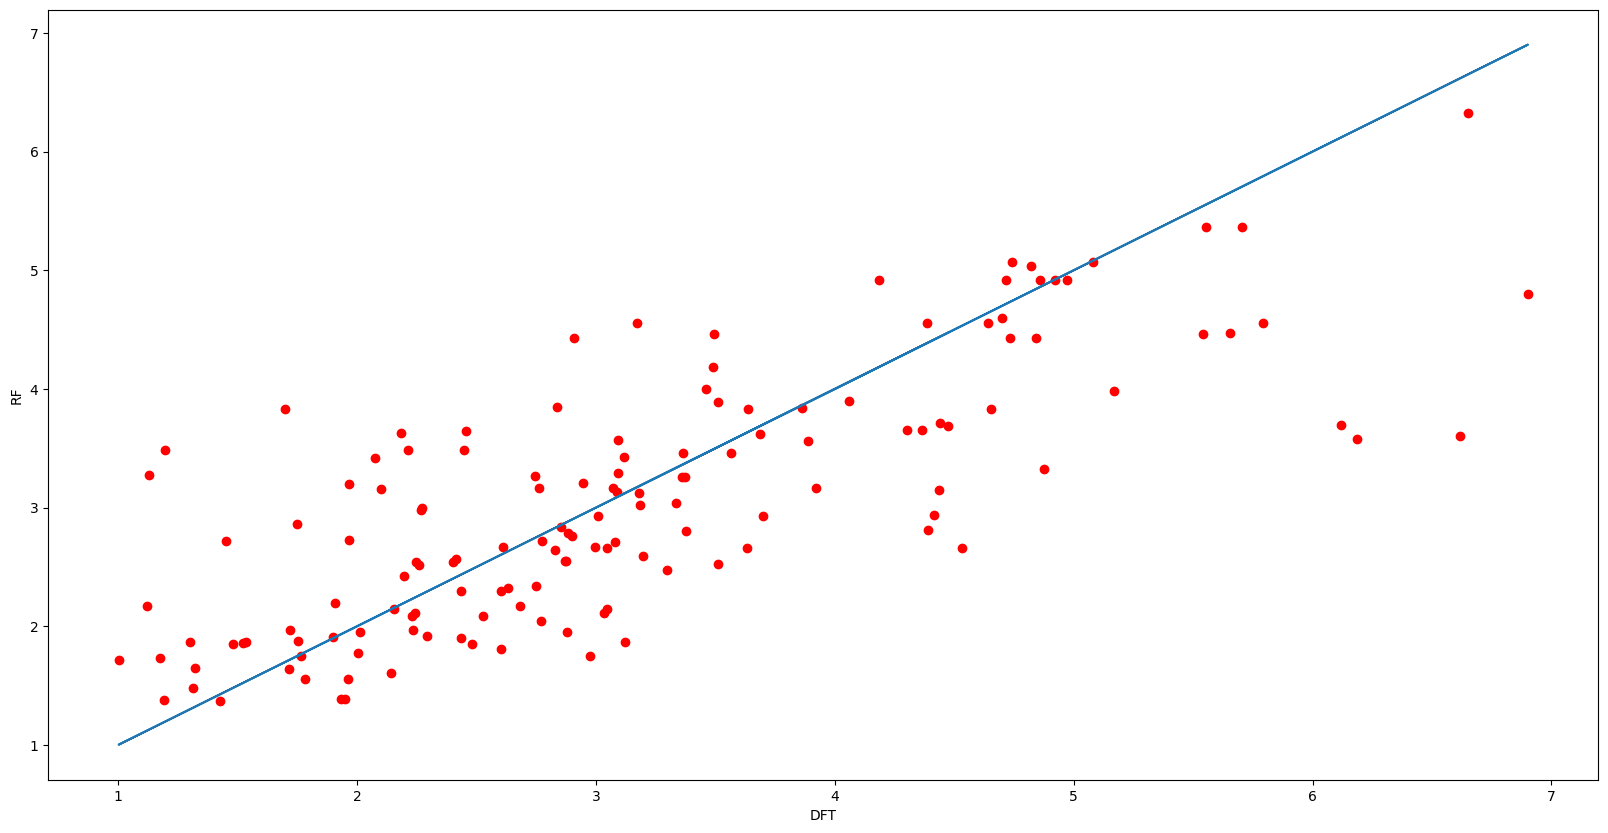

In [32]:
import matplotlib.pyplot as plt

xPlot=y_test
yPlot=y_pred
plt.figure(figsize=(20,10))
plt.plot(xPlot,yPlot,'ro')
plt.plot(xPlot,xPlot)
plt.xlabel('DFT')
plt.ylabel('RF')
plt.savefig('RF-Correlation_Test',bbox_inches='tight')

## LinearRegression

In [33]:
from sklearn.linear_model import LinearRegression

lr_model=LinearRegression()
lr_model.fit(X_train, y_train)
y_pred=lr_model.predict(X_test)
testing_accuracy = lr_model.score(X_test, y_test) * 100
models.append('LinearRegression')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: -41797844368265988999741440.0 %


In [34]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:840309774990.2787
R2:-4.179784436826599e+23


## MLP

In [35]:
from sklearn.neural_network import MLPRegressor

In [36]:
grid_param={'hidden_layer_sizes':[(),(),()],
           'solver':['sgd','lbfgs','adam'],
           'max_iter':[25,30,50,100],
            'alpha':[0.0001,0.001,0.01],
            'verbose':[True]
           }

In [37]:
mlp=MLPRegressor(random_state=42)

In [38]:
rand_ser = GridSearchCV(mlp,grid_param,n_jobs=-1,cv=10,verbose=2)
rand_ser.fit(X_train,y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(), (), ()],
                         'max_iter': [25, 30, 50, 100],
                         'solver': ['sgd', 'lbfgs', 'adam'],
                         'verbose': [True]},
             verbose=2)

In [39]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'alpha': 0.01, 'hidden_layer_sizes': (), 'max_iter': 100, 'solver': 'lbfgs', 'verbose': True}
best score:0.563018077214277


In [40]:
mlp_model=rand_ser.best_estimator_

In [41]:
y_pred=mlp_model.predict(X_test)
testing_accuracy = mlp_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 54.1 %


In [42]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:0.8802707915753565
R2:0.5413222886471056


## XGBoost

In [43]:
from xgboost import XGBRegressor

In [44]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)
testing_accuracy = xgb_model.score(X_test, y_test) * 100
models.append('XGBoost')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 64.0 %


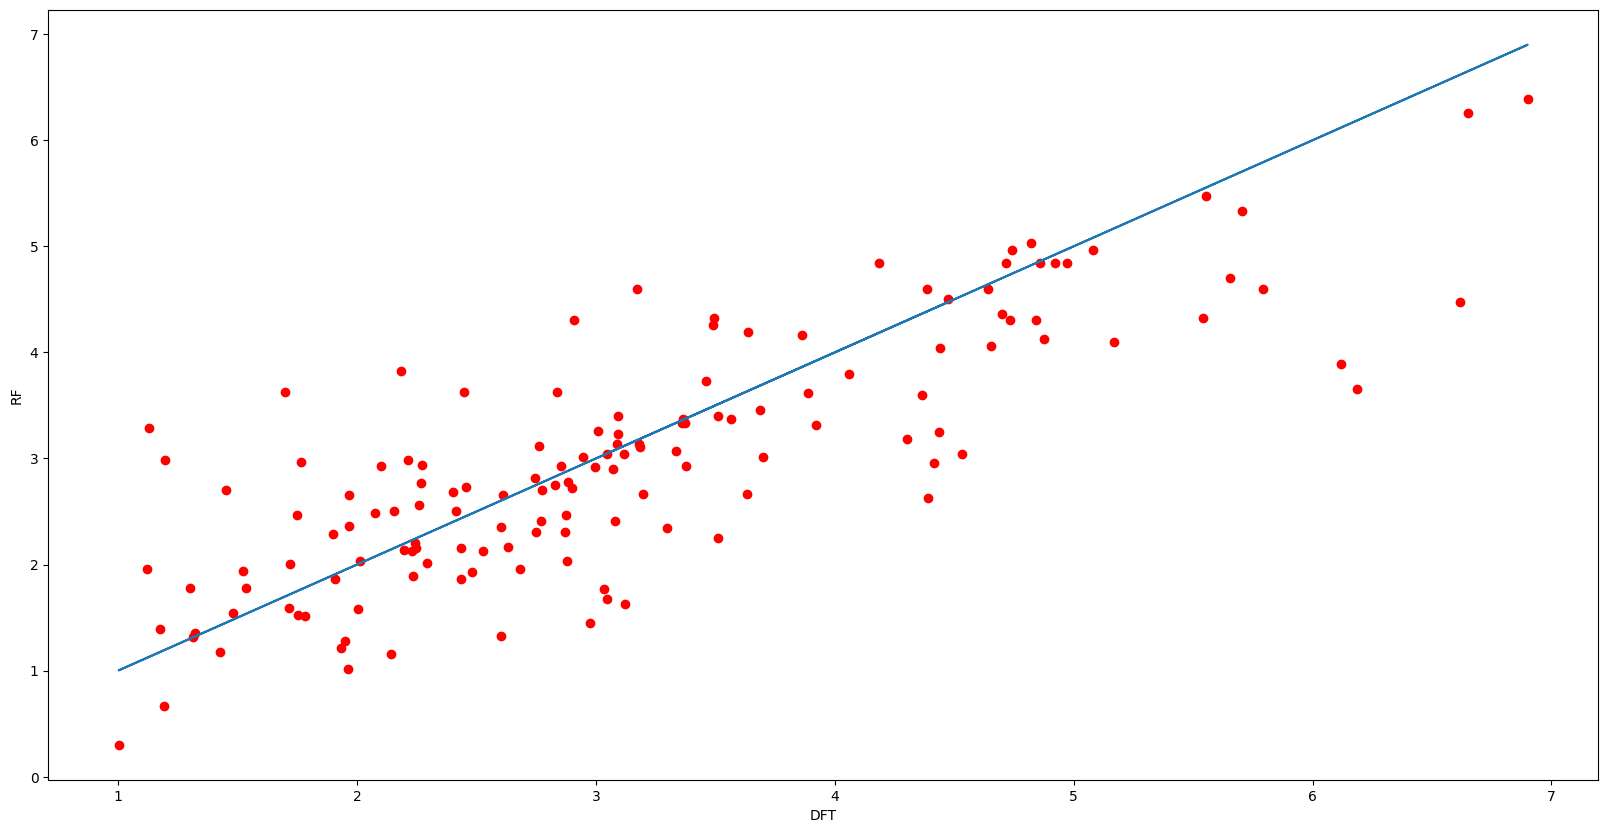

In [45]:

xPlot=y_test
yPlot=y_pred
plt.figure(figsize=(20,10))
plt.plot(xPlot,yPlot,'ro')
plt.plot(xPlot,xPlot)
plt.xlabel('DFT')
plt.ylabel('RF')
plt.savefig('RF-Correlation_Test',bbox_inches='tight')

## KNN

In [46]:
from sklearn.neighbors import KNeighborsRegressor

In [47]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train,y_train)
y_pred=knn_model.predict(X_test)
testing_accuracy = knn_model.score(X_test, y_test) * 100
models.append('KNN')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 38.3 %


In [48]:
import matplotlib.pyplot as plt

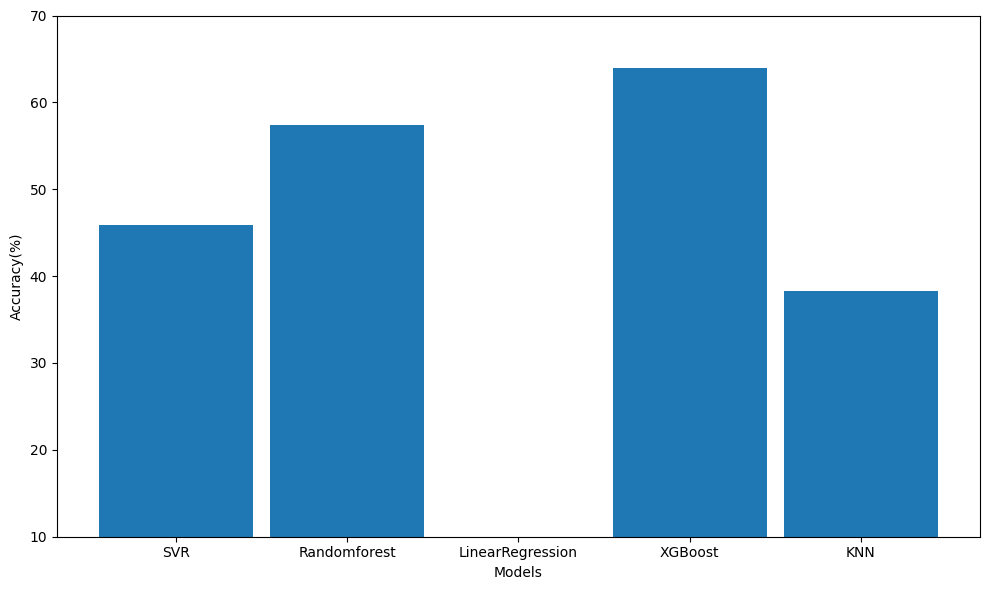

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(models,accuracy,width=0.9)
plt.xlabel('Models')
plt.ylabel('Accuracy(%)')
plt.ylim(10, 70)
plt.tight_layout()
plt.show()